<a href="https://colab.research.google.com/github/KelvinLam05/RFM-Analysis-with-K-means-Clustering/blob/main/RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project**

The aim of this project will be to perform a customer segmentation by applying RFM analysis and K-Means clustering.

**Data set information**

Detailed data on sales of consumer goods obtained by ‘scanning’ the bar codes for individual products at electronic points of sale in a retail store. The data provide detailed information about quantities, characteristics and values of goods sold as well as their prices.
The anonymized dataset includes 64.682 transactions of 5.242 SKU's sold to 22.625 customers during one year.

**Attribute information**

* Date of Sales Transaction

* Customer ID

* Transaction ID

* SKU Category ID

* SKU ID

* Quantity Sold

* Sales Amount

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Load the data
df = pd.read_csv('/content/scanner_data.csv')

In [ ]:
# Change column names to lower case
df.columns= df.columns.str.lower()

In [ ]:
# Examine the data
df.head()

,unnamed: 0,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [ ]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   unnamed: 0      131706 non-null  int64  
 1   date            131706 non-null  object 
 2   customer_id     131706 non-null  int64  
 3   transaction_id  131706 non-null  int64  
 4   sku_category    131706 non-null  object 
 5   sku             131706 non-null  object 
 6   quantity        131706 non-null  float64
 7   sales_amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [ ]:
# Convert the date column to a datetime
df['date'] = df['date'].apply(pd.to_datetime)

In [ ]:
# Convert the quantity column to an int
df['quantity'] = df['quantity'].apply(int)

In [ ]:
# Checking for missing values
df.isnull().sum().sort_values(ascending = False)

sales_amount      0
quantity          0
sku               0
sku_category      0
transaction_id    0
customer_id       0
date              0
unnamed: 0        0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   unnamed: 0      131706 non-null  int64         
 1   date            131706 non-null  datetime64[ns]
 2   customer_id     131706 non-null  int64         
 3   transaction_id  131706 non-null  int64         
 4   sku_category    131706 non-null  object        
 5   sku             131706 non-null  object        
 6   quantity        131706 non-null  int64         
 7   sales_amount    131706 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 8.0+ MB


**Engineer the features**

In [ ]:
# Create a dataframe of unique customers
df_customers = pd.DataFrame(df['customer_id'].unique())
df_customers.columns = ['customer_id']
df_customers.head()

,customer_id
0,2547
1,822
2,3686
3,3719
4,9200


In [ ]:
# Calculate customer recency
df_recency = df.groupby('customer_id')['date'].max().reset_index()
df_recency.columns = ['customer_id','recency_date']
df_customers = df_customers.merge(df_recency, on='customer_id')
df_customers['recency'] = round((pd.to_datetime('today') - df_customers['recency_date'])\
                                / np.timedelta64(1, 'D') ).astype(int)

In [ ]:
# Calculate order frequency
df_frequency = df.groupby('customer_id')['transaction_id'].nunique().reset_index()
df_frequency.columns = ['customer_id','frequency']
df_customers = df_customers.merge(df_frequency, on = 'customer_id')

In [ ]:
# Calculate monetary value
df_monetary = df.groupby('customer_id')['sales_amount'].sum().reset_index()
df_monetary.columns = ['customer_id','monetary']
df_customers = df_customers.merge(df_monetary, on = 'customer_id')

In [ ]:
df_customers.set_index('customer_id', inplace = True)

In [ ]:
df_customers.head()

,recency_date,recency,frequency,monetary
customer_id,,,,
2547,2016-11-04,1763,7,121.36
822,2016-03-02,2010,3,20.40
3686,2016-11-01,1766,15,405.44
3719,2016-12-01,1736,10,420.72
9200,2016-09-04,1824,2,18.01


**Examine the data**

If we use the Pandas describe( ) function to examine the summary statistics for our newly created df_customers dataframe we will see that we have a couple of issues to resolve first. K means expects our data to have equal variance, but the mean and std for each metric indicate that this isn’t the case. This is perfectly normal for RFM data, but it shows that we need to preprocess the data first to resolve this.

In [ ]:
df_customers['recency'].describe()

count    22625.000000
mean      1850.408796
std        109.263227
min       1706.000000
25%       1750.000000
50%       1826.000000
75%       1948.000000
max       2070.000000
Name: recency, dtype: float64

In [ ]:
df_customers['frequency'].describe()

count    22625.000000
mean         2.858873
std          4.000157
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         99.000000
Name: frequency, dtype: float64

In [ ]:
df_customers['monetary'].describe()

count    22625.000000
mean        69.747563
std        152.307769
min          0.140000
25%         10.170000
50%         23.850000
75%         63.070000
max       3985.940000
Name: monetary, dtype: float64

**Examine the statistical distributions**

Similarly, if we examine the statistical distributions of the data using a set of histograms, we will see that the data are strongly skewed. Again, this is perfectly normal in retail, but it shows us that we need to transform the data to make the distribution a bit more “normal”, in statistical terms.

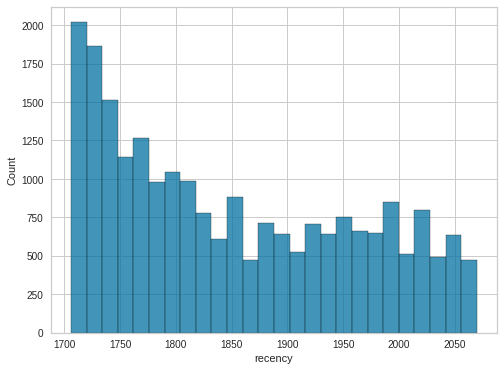

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.histplot(data = df_customers, x = 'recency')

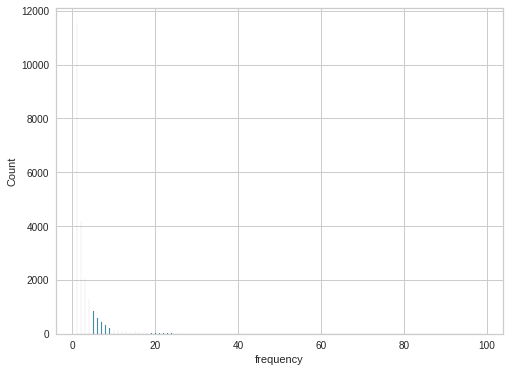

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.histplot(data = df_customers, x = 'frequency')

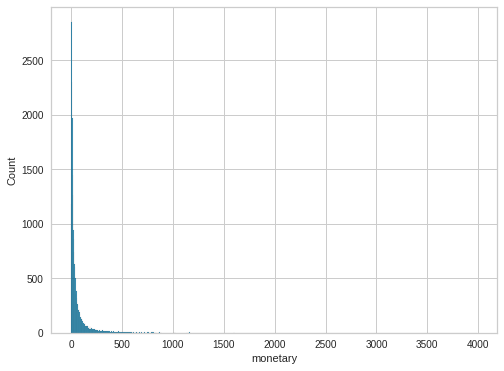

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.histplot(data = df_customers, x = 'monetary')

**Preprocess the data**

In [ ]:
# Drop the column recency_date
df_rfm = df_customers.drop(['recency_date'], axis = 1)

In [ ]:
df_rfm.head()

,recency,frequency,monetary
customer_id,,,
2547,1763,7,121.36
822,2010,3,20.40
3686,1766,15,405.44
3719,1736,10,420.72
9200,1824,2,18.01


As a general rule of thumb:

* If skewness is less than -1 or greater than 1, the distribution is highly skewed
* If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed
* If skewness is between -0.5 and 0.5, the distribution is approximately symmetric

In [ ]:
from scipy.stats import skew

In [ ]:
print('Skew in numberical features :', skew(df_rfm[['recency',	'frequency',	'monetary']], bias = False))

Skew in numberical features : [0.3942408  6.39295627 7.43197194]


The data is highly skewed, therefore we will perform data transformations to reduce the skewness of each skewed distribution.

In [ ]:
import copy

In [ ]:
# Make a deep copy of the dataframe
df_rfm_transformed = copy.deepcopy(df_rfm)

In [ ]:
df_rfm_transformed.head()

,recency,frequency,monetary
customer_id,,,
2547,1763,7,121.36
822,2010,3,20.40
3686,1766,15,405.44
3719,1736,10,420.72
9200,1824,2,18.01


In [ ]:
from scipy.stats import boxcox 

In [ ]:
# Apply Box-Cox transformation
df_rfm_transformed['frequency'] = boxcox(df_rfm_transformed['frequency'])[0]

In [ ]:
# Apply log transformation
df_rfm_transformed['monetary'] = np.log1p(df_rfm_transformed['monetary'])

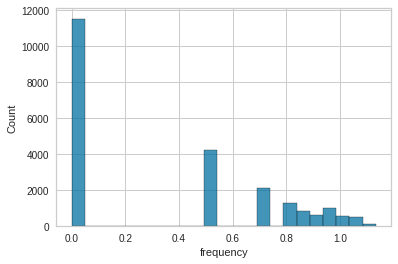

In [ ]:
# Transformed variable
sns.histplot(data = df_rfm_transformed, x = 'frequency')

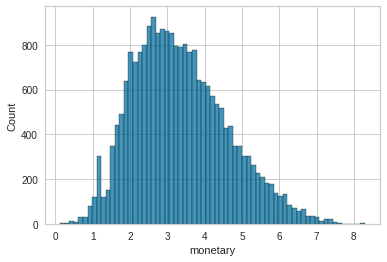

In [ ]:
# Transformed variable
sns.histplot(data = df_rfm_transformed, x = 'monetary')

In [ ]:
df_rfm_transformed.head()

,recency,frequency,monetary
customer_id,,,
2547,1763,0.941191,4.806968
822,2010,0.709051,3.063391
3686,1766,1.044835,6.007436
3719,1736,0.998186,6.044342
9200,1824,0.521307,2.944965


Transformation of the skewed variables has help correct the distribution of the variables. 

In [ ]:
print('Skew in numberical features :', skew(df_rfm_transformed[['frequency', 'monetary']], bias = False))

Skew in numberical features : [0.37443459 0.49656092]


Now, we will identify the outliers using a box plot and the interquartile range score. The box plot gives us information about data distribution and presence of outliers.

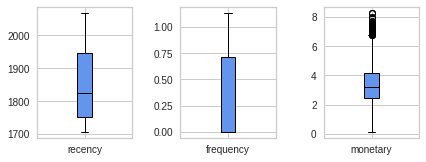

In [ ]:
# Identifying outliers 
df_rfm_transformed.plot(subplots = True, layout = (5,5), kind = 'box', figsize = (12,14), patch_artist = True, boxprops = dict(facecolor = 'cornflowerblue'),
            capprops = dict(color = 'black'),
            whiskerprops = dict(color = 'black'),
            flierprops = dict(markeredgecolor = 'black'),
            medianprops = dict(color= 'black')
            )
plt.tick_params(left = False, bottom = False)
plt.subplots_adjust(wspace = 0.5);

In [ ]:
df_rfm_transformed.describe()

,recency,frequency,monetary
count,22625.000000,22625.000000,22625.000000
mean,1850.408796,0.356430,3.351345
std,109.263227,0.386221,1.255086
min,1706.000000,0.000000,0.131028
25%,1750.000000,0.000000,2.413232
50%,1826.000000,0.000000,3.212858
75%,1948.000000,0.709051,4.159976
max,2070.000000,1.134159,8.290779


John Tukey distinguishes between possible and probable outliers. A possible outlier is located between the inner and the outer fence, whereas a probable outlier is located outside the outer fence.

While the inner and outer fence are usually not shown on the actual box plot, they can be calculated using the interquartile range (IQR) like this:

*IQR = Q3 - Q1, whereas Q3 : 75th quartile and Q1 : 25th quartile*

*Inner fence = [Q1 - 1.5 x IQR, Q3 + 1.5 x IQR]*

*Outer fence = [Q1 - 3 x IQR, Q3 + 3 x IQR]* 

The distribution’s inner fence is defined as 1.5 x IQR below Q1, and 1.5 x IQR above Q3. The outer fence is defined as 3 x IQR below Q1, and 3 x IQR above Q3. Following Tukey, only the probable outliers are treated, which lie outside the outer fence. 

In [ ]:
# Outer fences of the variable monetary
Q1 = df_rfm_transformed['monetary'].quantile(0.25)
Q3 = df_rfm_transformed['monetary'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

1.746744622569821


In [ ]:
outer_fence = 3 * IQR
outer_fence_le = Q1 - outer_fence
outer_fence_ue = Q3 + outer_fence

In [ ]:
print('Lower end outer fence: ', outer_fence_le)
print('Upper end outer fence: ', outer_fence_ue)

Lower end outer fence:  -2.827002254628354
Upper end outer fence:  9.400210103360394


The upper outer fence for the variable “monetary” is roughly 9.40, while the lower end is below zero. Because a monetary value below zero is not meaningful, the data should only be winsorized on its right tail. Now, we can look at values at different percentiles to set fold.

In [ ]:
# Explore different quantiles at the upper end
print('90% quantile:   ', df_rfm_transformed['monetary'].quantile(0.90))       
print('92.5% quantile: ', df_rfm_transformed['monetary'].quantile(0.925))      
print('95% quantile:   ', df_rfm_transformed['monetary'].quantile(0.95))       
print('97.5% quantile: ', df_rfm_transformed['monetary'].quantile(0.975))      
print('99% quantile:   ', df_rfm_transformed['monetary'].quantile(0.99))       
print('99.9% quantile: ', df_rfm_transformed['monetary'].quantile(0.999))      

90% quantile:    5.10388274187028
92.5% quantile:  5.339248153491578
95% quantile:    5.663848158245895
97.5% quantile:  6.123597462261067
99% quantile:    6.612431705224559
99.9% quantile:  7.399092679905674


The data points are located inside the outer fence. There are no probable outliers.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Apply StandardScaler to our data set
scaler = StandardScaler()
scaler.fit(df_rfm_transformed)
df_rfm_scaled = scaler.transform(df_rfm_transformed)

In [ ]:
# Transform into a dataframe
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, index = df_rfm.index, columns = df_rfm_transformed.columns)

In [ ]:
df_rfm_scaled.head()

,recency,frequency,monetary
customer_id,,,
2547,-0.800001,1.514089,1.159805
822,1.460645,0.913021,-0.229435
3686,-0.772544,1.782450,2.116310
3719,-1.047116,1.661665,2.145715
9200,-0.241704,0.426907,-0.323794


**Find the optimum k clusters**

We start by finding the optimal number of clusters for the k-means algorithm. We will use the elbow method. 

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

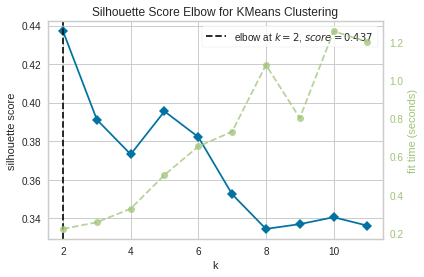

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k = (2, 12), metric = 'silhouette', timings = True)

# Fit the data to the visualizer
visualizer.fit(df_rfm_scaled)       

# Finalize and render the figure
visualizer.poof()      

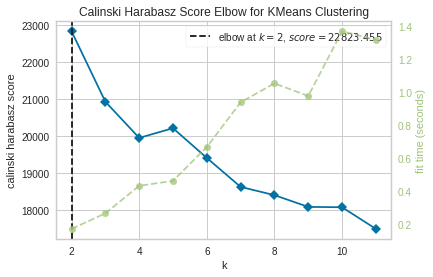

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k = (2, 12), metric = 'calinski_harabasz', timings = True)

# Fit the data to the visualizer
visualizer.fit(df_rfm_scaled)       

# Finalize and render the figure
visualizer.poof()        

I decided to use 2 clusters to perform k-means clustering.

**Apply KMeans clustering**

In [ ]:
# Choose n_clusters = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', n_init = 10 ,max_iter = 300, tol = 0.0001,  random_state = 42, algorithm = 'elkan')
kmeans.fit(df_rfm_scaled)

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
cluster_labels = kmeans.labels_

In [ ]:
# Assign the clusters to dataset
df_rfm['cluster'] = cluster_labels

In [ ]:
df_rfm.head()

,recency,frequency,monetary,cluster
customer_id,,,,
2547,1763,7,121.36,0
822,2010,3,20.40,1
3686,1766,15,405.44,0
3719,1736,10,420.72,0
9200,1824,2,18.01,0


**Creating the customer segments**

In [ ]:
df_rfm.groupby('cluster').agg(
    recency = ('recency', 'mean'),
    frequency = ('frequency', 'mean'),
    monetary = ('monetary', 'mean'),
    cluster_size = ('monetary','count')
).round(1).sort_values(by = 'recency')

,recency,frequency,monetary,cluster_size
cluster,,,,
0,1784.0,5.2,139.4,9545
1,1898.9,1.1,18.9,13080


Customers in cluster 0 made the last purchase a long time ago, but they spent a lot of money, so it is worth to encourage them to go back by providing them with some special offers. The worst customers are in cluster 1 – they made last purchase a long time ago and spent little money.

**Labeling the customers by segment**

Finally, to make our new segments a bit easier for marketers to understand, we can assign them each a label indicating their approximate value to the business. 

In [ ]:
segments = {0: 'gold', 1: 'silver'}
df_rfm['segment'] = df_rfm['cluster'].map(segments)
df_rfm.head()

,recency,frequency,monetary,cluster,segment
customer_id,,,,,
2547,1763,7,121.36,0,gold
822,2010,3,20.40,1,silver
3686,1766,15,405.44,0,gold
3719,1736,10,420.72,0,gold
9200,1824,2,18.01,0,gold
